## Importando variáveis de ambiente
Esse notebook prevê a existência de 2 variáveis de ambiente no arquivo .env desse projeto:
- TRAINED_MODELS_FOLDER

In [1]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path=".env")

TRAINED_MODELS_FOLDER = os.getenv("TRAINED_MODELS_FOLDER")

## Bibliotecas

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Transform

In [3]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

])

## DataSets e DataLoaders

In [4]:
from PIL import Image, UnidentifiedImageError

def safe_loader(path):
    try:
        return Image.open(path).convert("RGB")
    except UnidentifiedImageError:
        print(f"[ERRO] Imagem corrompida ignorada: {path}")
        # retorna uma imagem branca 224x224 (não quebra o DataLoader)
        return Image.new("RGB", (224, 224), (255, 255, 255))

In [5]:
data_dir = "/home/tatmiki/Documentos/Prog_Projects/cnn_peixes/data/splits"

test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"),  transform=val_transform,  loader=safe_loader)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(test_ds.classes)
print("Total de classes:", num_classes)

Total de classes: 30


## Carregar a ResNet50 pré-treinada

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Congelar early layers (opcional)
for param in model.parameters():
    param.requires_grad = True  # deixe True se quiser treinar tudo

# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

## Otimizador, Loss e Scheduler

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=3
)

## Função de teste e cálculo de métricas

In [8]:
def validate(model, loader, criterion, class_names=None):
    model.eval()

    all_labels = []
    all_preds_top1 = []
    all_preds_top3 = []
    all_preds_top5 = []

    total_loss = 0
    total_samples = 0
    correct_top1 = 0
    correct_top3 = 0
    correct_top5 = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validando"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)

            # TOP-1
            _, preds_top1 = outputs.max(dim=1)

            # TOP-3
            _, top3_idx = torch.topk(outputs, k=3, dim=1)

            # TOP-5
            _, top5_idx = torch.topk(outputs, k=5, dim=1)

            correct_top1 += (preds_top1 == labels).sum().item()

            for i in range(labels.size(0)):
                if labels[i].item() in top3_idx[i]:
                    correct_top3 += 1
            
            for i in range(labels.size(0)):
                if labels[i].item() in top5_idx[i]:
                    correct_top5 += 1

            all_labels.extend(labels.cpu().numpy())
            all_preds_top1.extend(preds_top1.cpu().numpy())
            all_preds_top3.extend(top3_idx.cpu().numpy())
            all_preds_top5.extend(top5_idx.cpu().numpy())

    # Métricas finais
    top1_acc = correct_top1 / total_samples
    top3_acc = correct_top3 / total_samples
    top5_acc = correct_top5 / total_samples

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds_top1, average="macro", zero_division=0
    )

    cm = confusion_matrix(all_labels, all_preds_top1)

    # PLOT DA MATRIZ DE CONFUSÃO
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        xticklabels=class_names if class_names else None,
        yticklabels=class_names if class_names else None,
        fmt="d"
    )
    plt.title("Matriz de Confusão - Top-1")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()

    # Retorno dos dados
    return {
        "loss": total_loss / total_samples,
        "top1_acc": top1_acc,
        "top3_acc": top3_acc,
        "top5_acc": top5_acc,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "confusion_matrix": cm,
        "top3_preds": all_preds_top3,
        "top5_preds": all_preds_top5
    }


## Função de plot da matriz de confusão

In [9]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.title("Matriz de Confusão")
    plt.show()


## Exibição dos resultados

Validando: 100%|██████████| 36/36 [00:06<00:00,  5.18it/s]


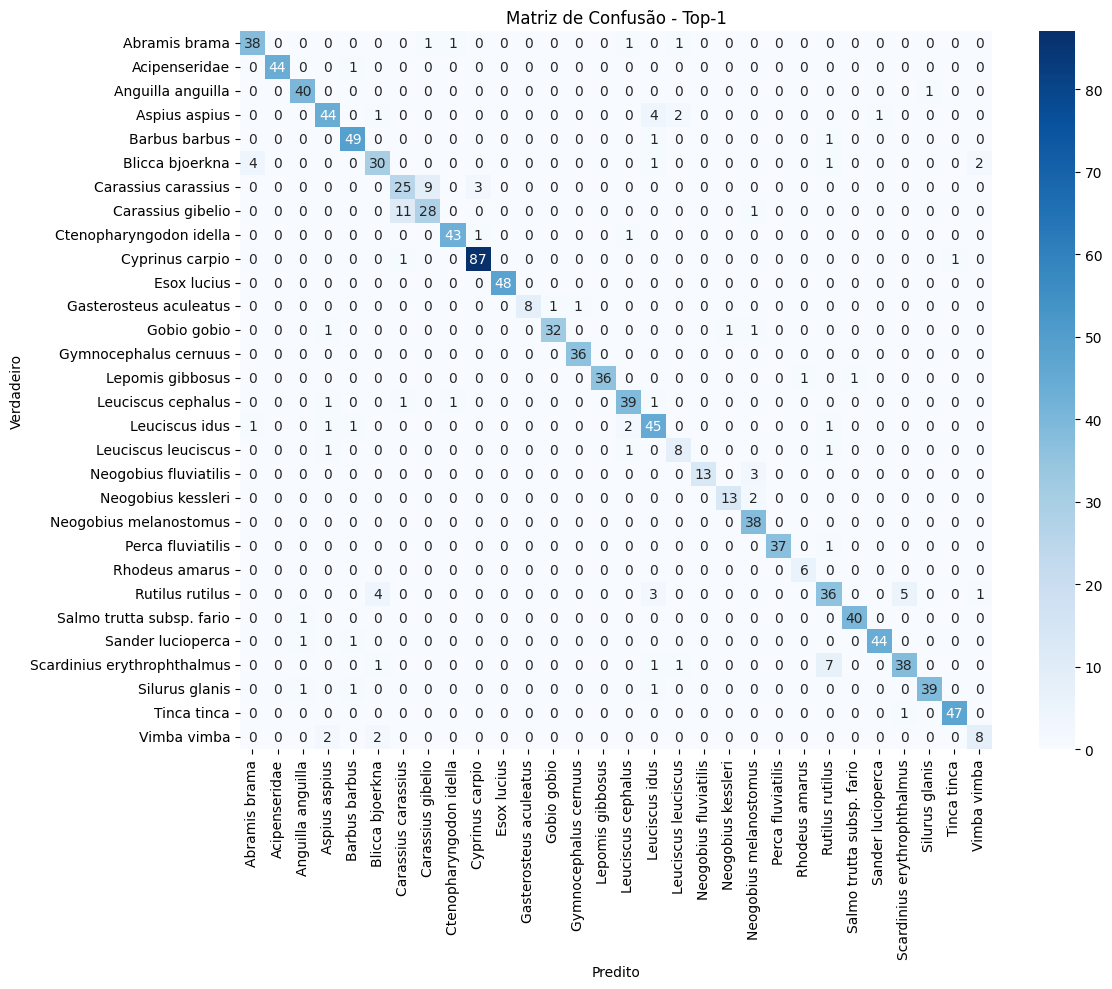


===== RESULTADOS =====
Loss: 0.5223
Top-1 Acc: 0.9027
Top-3 Acc: 0.9705
Top-5 Acc: 0.9852
Precision (macro): 0.8959
Recall (macro): 0.8876
F1 (macro): 0.8902

Exemplo Top-3 das primeiras 5 predições:
Imagem 0: ['Abramis brama', 'Tinca tinca', 'Anguilla anguilla']
Imagem 1: ['Abramis brama', 'Blicca bjoerkna', 'Leuciscus idus']
Imagem 2: ['Abramis brama', 'Blicca bjoerkna', 'Carassius gibelio']
Imagem 3: ['Abramis brama', 'Tinca tinca', 'Perca fluviatilis']
Imagem 4: ['Leuciscus leuciscus', 'Vimba vimba', 'Blicca bjoerkna']

Exemplo Top-5 das primeiras 5 predições:
Imagem 0: ['Abramis brama', 'Tinca tinca', 'Anguilla anguilla', 'Neogobius melanostomus', 'Silurus glanis']
Imagem 1: ['Abramis brama', 'Blicca bjoerkna', 'Leuciscus idus', 'Carassius gibelio', 'Tinca tinca']
Imagem 2: ['Abramis brama', 'Blicca bjoerkna', 'Carassius gibelio', 'Tinca tinca', 'Leuciscus idus']
Imagem 3: ['Abramis brama', 'Tinca tinca', 'Perca fluviatilis', 'Carassius carassius', 'Silurus glanis']
Imagem 4: ['L

In [10]:
model.load_state_dict(torch.load(os.path.join(TRAINED_MODELS_FOLDER,"best_resnet50.pth")))

results = validate(model, test_loader, criterion, class_names=test_ds.classes)

print("\n===== RESULTADOS =====")
print(f"Loss: {results['loss']:.4f}")
print(f"Top-1 Acc: {results['top1_acc']:.4f}")
print(f"Top-3 Acc: {results['top3_acc']:.4f}")
print(f"Top-5 Acc: {results['top5_acc']:.4f}")
print(f"Precision (macro): {results['precision_macro']:.4f}")
print(f"Recall (macro): {results['recall_macro']:.4f}")
print(f"F1 (macro): {results['f1_macro']:.4f}")

print("\nExemplo Top-3 das primeiras 5 predições:")
for i in range(5):
    top3 = results["top3_preds"][i]
    print(f"Imagem {i}: {[test_ds.classes[c] for c in top3]}")

print("\nExemplo Top-5 das primeiras 5 predições:")
for i in range(5):
    top5 = results["top5_preds"][i]
    print(f"Imagem {i}: {[test_ds.classes[c] for c in top5]}")
